# Import Libraries

In [922]:

# Standard Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Loading and Initial Exploration

In [923]:
os.chdir("C:/Users/USER/Desktop/GitHub/Nigeria-Housing-Price-Prediction")

In [924]:
# Load datasets
DATA_PATH_NIGERIA = os.getenv("DATA_PATH", default="dataset/nigeria_houses_data.csv")
nigeria_df = pd.read_csv(DATA_PATH_NIGERIA)

# Check if file exists
if not os.path.exists(DATA_PATH_NIGERIA):
    raise FileNotFoundError(f"The data file at {DATA_PATH_NIGERIA} was not found.")


In [925]:
COLUMNS_CONFIG = os.getenv("COLUMNS_CONFIG", default="config/columns.json")
# Save column configurations with data types for consistency
columns = {col: nigeria_df[col].dtype.name for col in nigeria_df.columns}
with open(COLUMNS_CONFIG, "w") as f:
    json.dump(columns, f, indent=4)

In [926]:
nigeria_df.info()
display(nigeria_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


In [927]:
nigeria_df.shape

(24326, 8)

The dataset consists of 24,326 entries (rows) and 8 columns (features). This indicates that we have data for 24,326 properties across 8 features, which include both numeric and categorical attributes.

# Initial Observations and Data Understanding

In [928]:
nigeria_df.describe()

,bedrooms,bathrooms,toilets,parking_space,price
count,24326.000000,24326.000000,24326.000000,24326.000000,2.432600e+04
mean,4.338814,4.600798,5.176355,4.041725,3.013802e+08
std,1.138497,1.163161,1.226253,1.399936,1.220403e+10
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04
25%,4.000000,4.000000,5.000000,4.000000,5.200000e+07
50%,4.000000,5.000000,5.000000,4.000000,8.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,1.600000e+08
max,9.000000,9.000000,9.000000,9.000000,1.800000e+12


**Bedrooms, Bathrooms, Toilets, and Parking Space**

- The mean values indicate that most properties are moderately sized, with an average of 4-5 bedrooms, 4-5 bathrooms, 5 toilets, and 4 parking spaces.
- The maximum values (e.g., 9 bedrooms, 9 bathrooms, etc.) indicate that the dataset contains some large, luxury properties.

**Price**

- The mean price is around ₦301 million.
- The standard deviation is very high (₦12.2 billion), indicating that there is significant variation in property prices.
- The min value is ₦90 million, and the max value is a staggering ₦1.8 trillion, suggesting that there are both very affordable and extremely expensive properties.

In [929]:
nigeria_df.describe(include=['object'])

,title,town,state
count,24326,24326,24326
unique,7,189,25
top,Detached Duplex,Lekki,Lagos
freq,13992,10895,18445


**Title**

- There are 7 unique property types in the dataset, with 'Detached Duplex' being the most frequent (13,992 occurrences). This indicates that detached houses are the most common property type.

**Town**

- The dataset contains properties from 189 different towns. The most frequent town is Lekki with 10,895 occurrences, suggesting that Lekki is a popular area for real estate listings in Nigeria.

**State**

- There are 25 unique states, with Lagos being the most frequent (18,445 properties), indicating a strong real estate presence in Lagos.

In [930]:
print("Column Names:", nigeria_df.columns.tolist())

Column Names: ['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'title', 'town', 'state', 'price']


#  Data Cleaning
- Addressing Datatypes
- Missing Values Analysis
- Duplicate Records
- Outliers Detection

## Addressing Datatypes

In [931]:
nigeria_df.dtypes

bedrooms         float64
bathrooms        float64
toilets          float64
parking_space    float64
title             object
town              object
state             object
price            float64
dtype: object

In [932]:
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


We can see that `bedrooms`, `bathrooms`, `toilets` and `parking_space` are all float datatypes instead of interger. We will need to address that.

In [933]:
nigeria_df['bedrooms'] = nigeria_df['bedrooms'].astype('int64')
nigeria_df['bathrooms'] = nigeria_df['bathrooms'].astype('int64')
nigeria_df['toilet'] = nigeria_df['toilets'].astype('int64')
nigeria_df['parking_space'] = nigeria_df['parking_space'].astype('int64')

## Missing Values Analysis

In [934]:
nigeria_df.isnull().sum()

bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
toilet           0
dtype: int64

we can see that there are no missing values

## Duplicate Records

In [935]:
nigeria_df.duplicated().sum()

10438

In [936]:
# Keep the first occurrence
initial_shape = nigeria_df.shape
nigeria_df = nigeria_df.drop_duplicates()
print(f"Removed {initial_shape[0] - nigeria_df.shape[0]} duplicate rows.")

Removed 10438 duplicate rows.


## Outlier Detection

In [937]:
nigeria_df.select_dtypes('number').skew()

bedrooms           0.303463
bathrooms          0.004096
toilets           -0.316401
parking_space      0.499450
price            102.064848
toilet            -0.316401
dtype: float64

The skewness values we’ve calculated for the numerical features show the following:

- bedrooms: 0.303 — Mild positive skew.
- bathrooms: 0.004 — Almost symmetric (negligible skew).
- toilets: -0.316 — Mild negative skew.
- parking_space: 0.499 — Moderate positive skew.
- price: 102.065 — Strong positive skew.

<Axes: xlabel='price'>

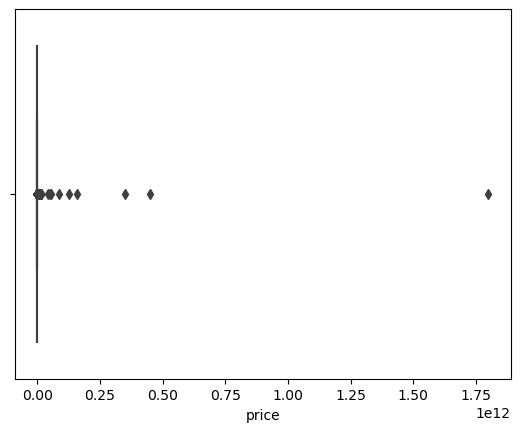

In [938]:
import seaborn as sns
sns.boxplot(x=nigeria_df['price'])


<Axes: >

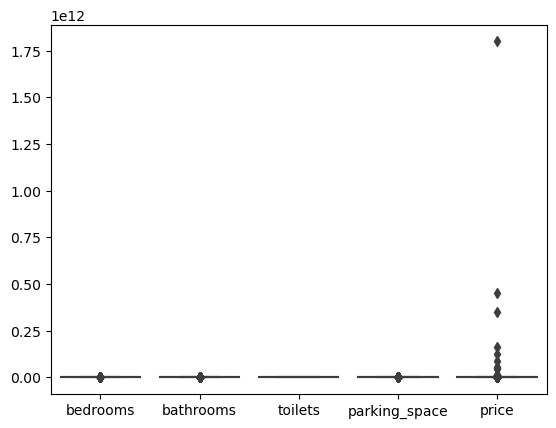

In [939]:
import seaborn as sns
sns.boxplot(data=nigeria_df[['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'price']])


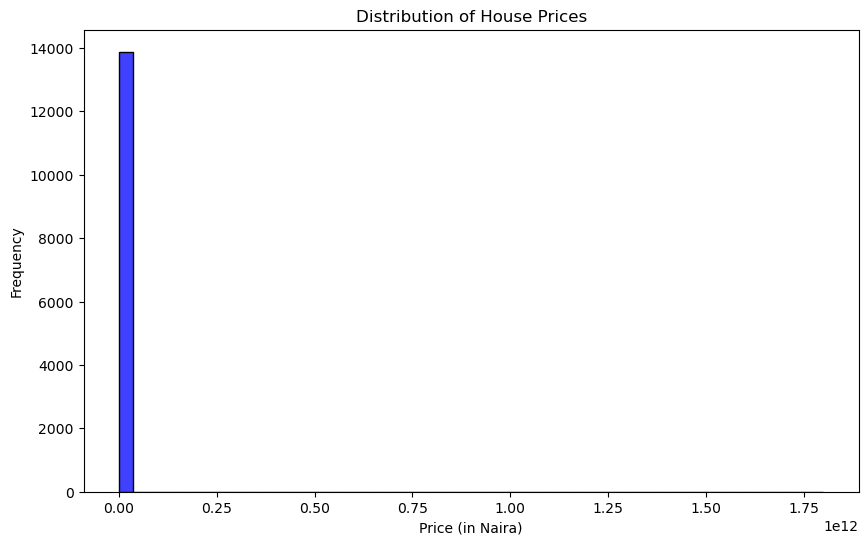

In [940]:
# Plotting the histogram for the 'price' column
plt.figure(figsize=(10, 6))
sns.histplot(nigeria_df['price'], kde=False, color='blue', bins=50)
plt.title('Distribution of House Prices')
plt.xlabel('Price (in Naira)')
plt.ylabel('Frequency')
plt.show()


From the above Outlier detection and also confirming with Visualization method we can wee that only `price` feature is heavily right skewed. we will need to address this. 

In [941]:
# Apply log transformation to the 'price' feature
nigeria_df['price'] = np.log1p(nigeria_df['price'])

# Cap extreme values in 'bedrooms' and 'bathrooms' to the 99th percentile
for col in ['toilets', 'parking_space']:
    upper_limit = nigeria_df[col].quantile(0.99)
    nigeria_df[col] = np.where(nigeria_df[col] > upper_limit, upper_limit, nigeria_df[col])


nigeria_df.select_dtypes('number').skew()

bedrooms         0.303463
bathrooms        0.004096
toilets         -0.439436
parking_space    0.420149
price            0.373771
toilet          -0.316401
dtype: float64

# Exploratory Data Analysis (EDA)

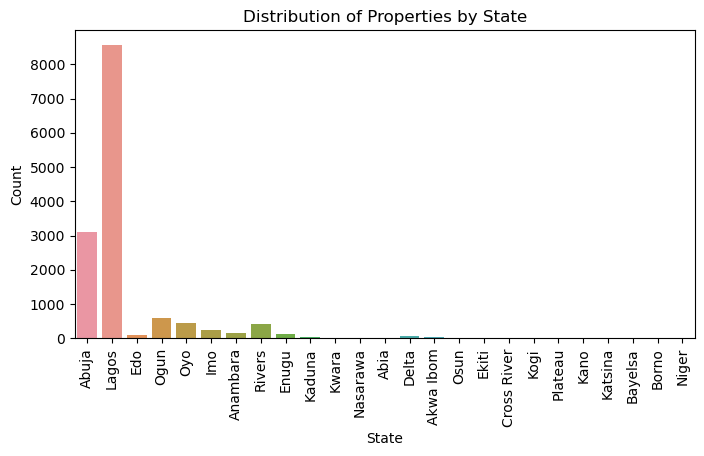

In [942]:
plt.figure(figsize=(8, 4))
sns.countplot(x='state', data=nigeria_df)
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.title('Distribution of Properties by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

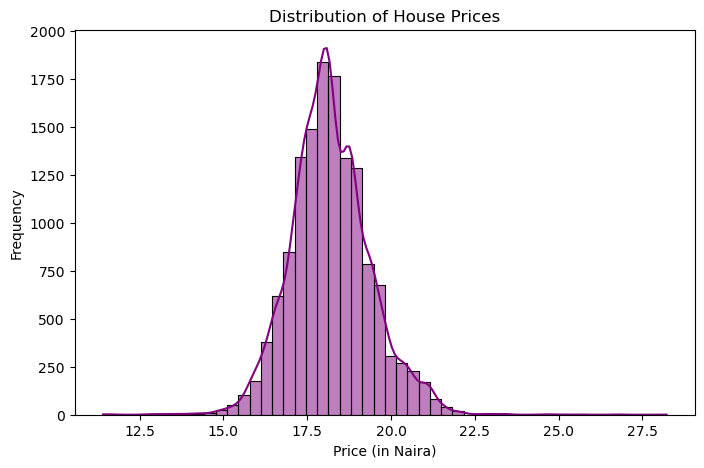

In [943]:
# Plot histogram with KDE for price
plt.figure(figsize=(8, 5))
sns.histplot(nigeria_df['price'], kde=True, bins=50, color='purple')
plt.title('Distribution of House Prices')
plt.xlabel('Price (in Naira)')
plt.ylabel('Frequency')
plt.show()

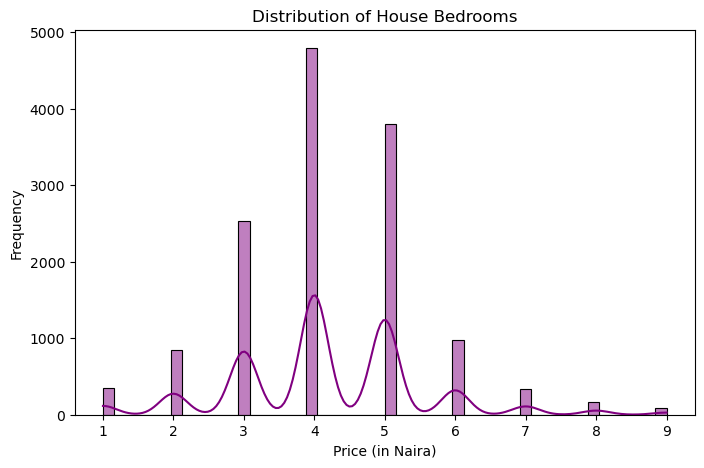

In [944]:
# Plot histogram with KDE for price
plt.figure(figsize=(8, 5))
sns.histplot(nigeria_df['bedrooms'], kde=True, bins=50, color='purple')
plt.title('Distribution of House Bedrooms')
plt.xlabel('Price (in Naira)')
plt.ylabel('Frequency')
plt.show();

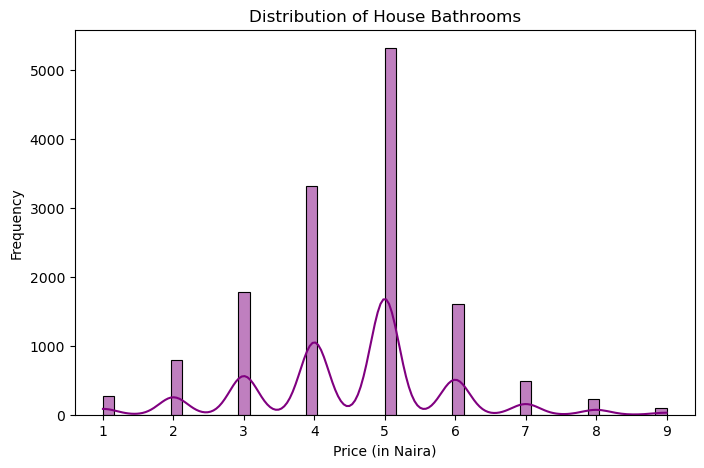

In [945]:
# Plot histogram with KDE for price
plt.figure(figsize=(8, 5))
sns.histplot(nigeria_df['bathrooms'], kde=True, bins=50, color='purple')
plt.title('Distribution of House Bathrooms')
plt.xlabel('Price (in Naira)')
plt.ylabel('Frequency')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_56120\3973947386.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(nigeria_df.corr(), annot=True)


<Axes: >

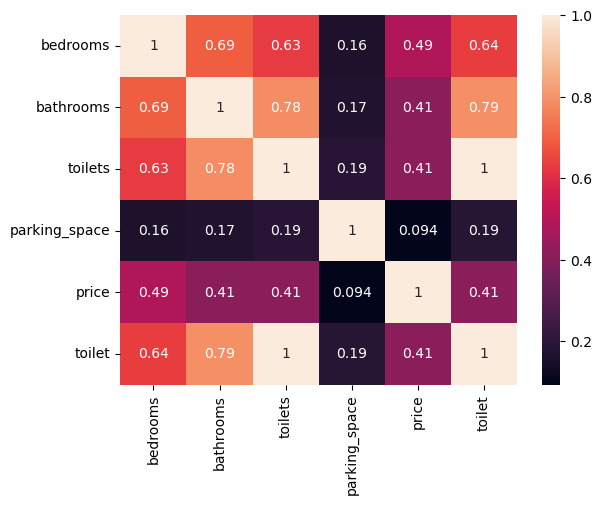

In [946]:
sns.heatmap(nigeria_df.corr(), annot=True)

## Categorical Analysis

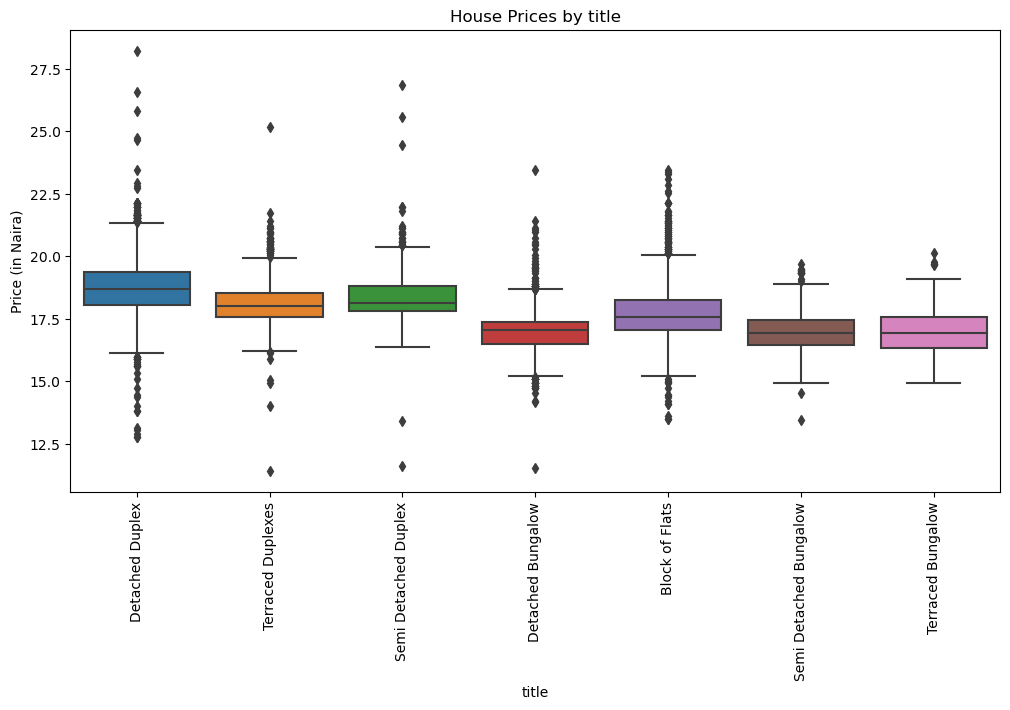

In [947]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='title', y='price', data=nigeria_df)
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.title('House Prices by title')
plt.xlabel('title')
plt.ylabel('Price (in Naira)')
plt.show();

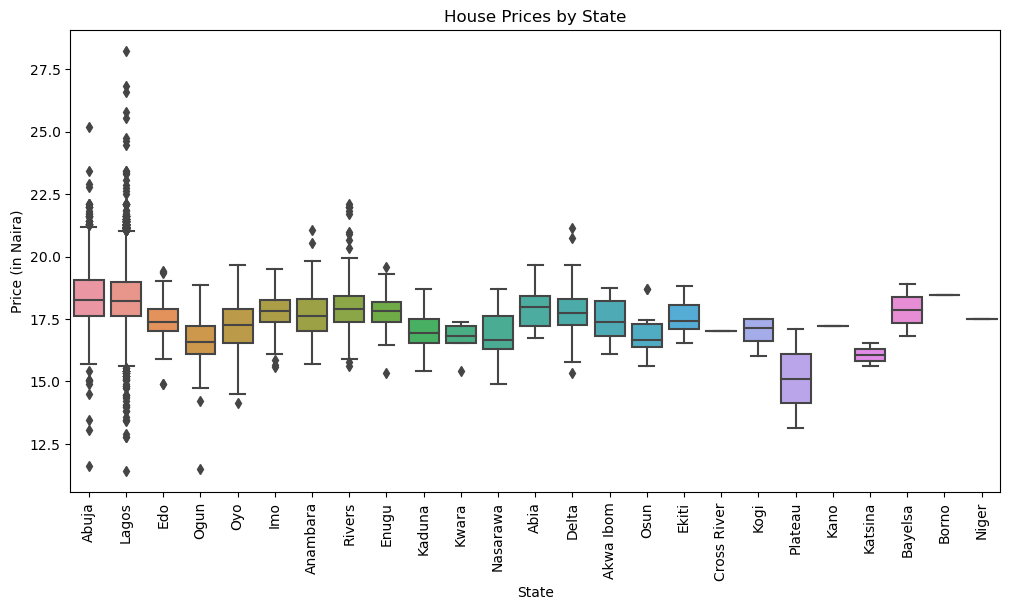

In [948]:
# Apply log transformation if needed
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='price', data=nigeria_df)
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.title('House Prices by State')
plt.xlabel('State')
plt.ylabel('Price (in Naira)')
plt.show()


# Data Preprocessing and Feature Engineering

In [949]:
nigeria_df['title'].unique()

array(['Detached Duplex', 'Terraced Duplexes', 'Semi Detached Duplex',
       'Detached Bungalow', 'Block of Flats', 'Semi Detached Bungalow',
       'Terraced Bungalow'], dtype=object)

In [950]:
nigeria_df['state'].unique()

array(['Abuja', 'Lagos', 'Edo', 'Ogun', 'Oyo', 'Imo', 'Anambara',
       'Rivers', 'Enugu', 'Kaduna', 'Kwara', 'Nasarawa', 'Abia', 'Delta',
       'Akwa Ibom', 'Osun', 'Ekiti', 'Cross River', 'Kogi', 'Plateau',
       'Kano', 'Katsina', 'Bayelsa', 'Borno', 'Niger'], dtype=object)

In [951]:
nigeria_df['town'].unique()

array(['Mabushi', 'Katampe', 'Lekki', 'Ajah', 'Epe', 'Lokogoma District',
       'Oredo', 'Victoria Island (VI)', 'Mowe Ofada', 'Ikeja', 'Ikoyi',
       'Magodo', 'Kaura', 'Galadimawa', 'Gwarinpa', 'Abeokuta North',
       'Lugbe District', 'Ibeju Lekki', 'Yaba', 'Sango Ota',
       'Ifako-Ijaiye', 'Agege', 'Ikorodu', 'Jahi', 'Ibadan', 'Orozo',
       'Ifo', 'Owerri North', 'Guzape District', 'Idu Industrial',
       'Owerri Municipal', 'Isheri North', 'Utako', 'Port Harcourt',
       'Kuje', 'Isheri', 'Life Camp', 'Ipaja', 'Ado-Odo/Ota', 'Dape',
       'Mushin', 'Ejigbo', 'Isolo', 'Ojodu', 'Gaduwa', 'Enugu', 'Dakwo',
       'Asokoro District', 'Alimosho', 'Sagamu', 'Chikun', 'Egbeda',
       'Wuye', 'Kubwa', 'Shomolu', 'Ogudu', 'Owerri West', 'Ibafo',
       'Surulere', 'Obio-Akpor', 'Ayobo', 'Apo', 'Mowe Town',
       'Ibadan South-West', 'Wuse 2', 'Durumi', 'Simawa', 'Arepo',
       'Ikotun', 'Oluyole', 'Maitama District', 'Maryland', 'Ido',
       'Karsana', 'Wuse', 'Ilorin West', 

In [952]:
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,toilet
0,6,5,5.0,4.0,Detached Duplex,Mabushi,Abuja,19.924758,5
1,4,5,5.0,4.0,Terraced Duplexes,Katampe,Abuja,20.500122,5
2,4,5,5.0,4.0,Detached Duplex,Lekki,Lagos,18.603002,5
3,4,4,5.0,6.0,Detached Duplex,Ajah,Lagos,17.504390,5
4,4,4,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,18.132999,5


In [953]:
# Create a new feature 'price_per_bedroom'
nigeria_df['price_per_bedroom'] = nigeria_df['price'] / nigeria_df['bedrooms']

# Total_rooms: sum of bedrooms + bathrooms + toilets
nigeria_df['total_rooms'] = nigeria_df['bedrooms'] + nigeria_df['bathrooms'] + nigeria_df['toilets']
# Room-to-parking ratio: ratio of total rooms to parking spaces
nigeria_df['room_to_parking'] = nigeria_df['total_rooms'] / (nigeria_df['parking_space'] + 1)  # Avoid division by zero
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,toilet,price_per_bedroom,total_rooms,room_to_parking
0,6,5,5.0,4.0,Detached Duplex,Mabushi,Abuja,19.924758,5,3.320793,16.0,3.200000
1,4,5,5.0,4.0,Terraced Duplexes,Katampe,Abuja,20.500122,5,5.125031,14.0,2.800000
2,4,5,5.0,4.0,Detached Duplex,Lekki,Lagos,18.603002,5,4.650751,14.0,2.800000
3,4,4,5.0,6.0,Detached Duplex,Ajah,Lagos,17.504390,5,4.376098,13.0,1.857143
4,4,4,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,18.132999,5,4.533250,13.0,4.333333


In [954]:
# Set up paths
TITLE_CONFIG_PATH = os.getenv("TITLE_CONFIG", default="config/title.json")
STATE_CONFIG_PATH = os.getenv("STATE_CONFIG", default="config/state_target_enc.json")
TOWN_CONFIG_PATH = os.getenv("TOWN_CONFIG", default="config/town_freq_enc.json")

# 4. One-Hot Encoding for 'title' and save mappings
nigeria_df = pd.get_dummies(nigeria_df, columns=['title'], prefix='title')
encoded_title_columns = [col for col in nigeria_df.columns if col.startswith('title_')]
title_mapping = {col.replace('title_', ''): col for col in encoded_title_columns}

with open(TITLE_CONFIG_PATH, "w") as f:
    json.dump(title_mapping, f, indent=4)

# 5. Target encoding for 'state' based on average 'price'
state_target_enc = nigeria_df.groupby('state')['price'].mean().to_dict()

with open(STATE_CONFIG_PATH, "w") as f:
    json.dump(state_target_enc, f, indent=4)

# Apply the target encoding to the 'state' column and drop the original column
nigeria_df['state_target_enc'] = nigeria_df['state'].map(state_target_enc)
nigeria_df.drop(columns=['state'], inplace=True)

# 6. Frequency encoding for 'town'
town_freq_enc = nigeria_df['town'].value_counts(normalize=True).to_dict()

with open(TOWN_CONFIG_PATH, "w") as f:
    json.dump(town_freq_enc, f, indent=4)

# Apply the frequency encoding to the 'town' column and drop the original column
nigeria_df['town_freq_enc'] = nigeria_df['town'].map(town_freq_enc)
nigeria_df.drop(columns=['town'], inplace=True)

# Display the first few rows to verify the final transformations
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,price,toilet,price_per_bedroom,total_rooms,room_to_parking,title_Block of Flats,title_Detached Bungalow,title_Detached Duplex,title_Semi Detached Bungalow,title_Semi Detached Duplex,title_Terraced Bungalow,title_Terraced Duplexes,state_target_enc,town_freq_enc
0,6,5,5.0,4.0,19.924758,5,3.320793,16.0,3.200000,0,0,1,0,0,0,0,18.417556,0.004392
1,4,5,5.0,4.0,20.500122,5,5.125031,14.0,2.800000,0,0,0,0,0,0,1,18.417556,0.016273
2,4,5,5.0,4.0,18.603002,5,4.650751,14.0,2.800000,0,0,1,0,0,0,0,18.331302,0.247912
3,4,4,5.0,6.0,17.504390,5,4.376098,13.0,1.857143,0,0,1,0,0,0,0,18.331302,0.087414
4,4,4,5.0,2.0,18.132999,5,4.533250,13.0,4.333333,0,0,0,0,1,0,0,18.331302,0.247912


In [955]:
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,price,toilet,price_per_bedroom,total_rooms,room_to_parking,title_Block of Flats,title_Detached Bungalow,title_Detached Duplex,title_Semi Detached Bungalow,title_Semi Detached Duplex,title_Terraced Bungalow,title_Terraced Duplexes,state_target_enc,town_freq_enc
0,6,5,5.0,4.0,19.924758,5,3.320793,16.0,3.200000,0,0,1,0,0,0,0,18.417556,0.004392
1,4,5,5.0,4.0,20.500122,5,5.125031,14.0,2.800000,0,0,0,0,0,0,1,18.417556,0.016273
2,4,5,5.0,4.0,18.603002,5,4.650751,14.0,2.800000,0,0,1,0,0,0,0,18.331302,0.247912
3,4,4,5.0,6.0,17.504390,5,4.376098,13.0,1.857143,0,0,1,0,0,0,0,18.331302,0.087414
4,4,4,5.0,2.0,18.132999,5,4.533250,13.0,4.333333,0,0,0,0,1,0,0,18.331302,0.247912


**For encoding a categorical feature with a high number of unique categories, like town, the most efficient and commonly used methods is**
- Target Encoding or Mean Encoding
Method: Replace each unique town with the mean of the target variable for that town.
Use Case: Works well when there are many categories. It helps retain useful information while reducing dimensionality.
Implementation: Calculate the average target value for each town and replace the town names with those averages.
Pros: Keeps category-level information related to the target variable without creating numerous columns.

In [956]:
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,price,toilet,price_per_bedroom,total_rooms,room_to_parking,title_Block of Flats,title_Detached Bungalow,title_Detached Duplex,title_Semi Detached Bungalow,title_Semi Detached Duplex,title_Terraced Bungalow,title_Terraced Duplexes,state_target_enc,town_freq_enc
0,6,5,5.0,4.0,19.924758,5,3.320793,16.0,3.200000,0,0,1,0,0,0,0,18.417556,0.004392
1,4,5,5.0,4.0,20.500122,5,5.125031,14.0,2.800000,0,0,0,0,0,0,1,18.417556,0.016273
2,4,5,5.0,4.0,18.603002,5,4.650751,14.0,2.800000,0,0,1,0,0,0,0,18.331302,0.247912
3,4,4,5.0,6.0,17.504390,5,4.376098,13.0,1.857143,0,0,1,0,0,0,0,18.331302,0.087414
4,4,4,5.0,2.0,18.132999,5,4.533250,13.0,4.333333,0,0,0,0,1,0,0,18.331302,0.247912


In [957]:
correlation_matrix = nigeria_df.corr()
print(correlation_matrix['price'])  # Or visualize correlations

bedrooms                        0.489991
bathrooms                       0.406273
toilets                         0.409218
parking_space                   0.094126
price                           1.000000
toilet                          0.409157
price_per_bedroom              -0.200024
total_rooms                     0.484678
room_to_parking                 0.246708
title_Block of Flats           -0.130361
title_Detached Bungalow        -0.411562
title_Detached Duplex           0.453786
title_Semi Detached Bungalow   -0.179454
title_Semi Detached Duplex      0.038718
title_Terraced Bungalow        -0.109728
title_Terraced Duplexes        -0.037571
state_target_enc                0.350765
town_freq_enc                   0.165738
Name: price, dtype: float64


In [959]:
# Define the path for saving training columns configuration
TRAINING_COLUMNS_CONFIG = os.getenv("TRAINING_COLUMNS_CONFIG", default="config/training_columns.json")

# Save feature columns (excluding target column 'price') to the configuration file
with open(TRAINING_COLUMNS_CONFIG, "w") as f:
    # Convert the feature columns to JSON, excluding 'price'
    feature_columns = {col: nigeria_df[col].dtype.name for col in nigeria_df.columns if col != "price"}
    json.dump(feature_columns, f, indent=4)

print("Training columns configuration saved successfully.")

Training columns configuration saved successfully.


# Data Splitting

In [961]:
# Define target and features
X = nigeria_df.drop('price', axis=1)  # Features
y = nigeria_df['price']   # Target

# Step 1: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Data Scaling

In [962]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform the data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (no fitting on test data)
X_test_scaled = scaler.transform(X_test)

# Model Development and Training

## Traditional Models
- Linear Regression

In [963]:
# Initialize and train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Record performance metrics
print(f"Linear Regression - MAE: {mae_linear}, MSE: {mse_linear}, RMSE: {rmse_linear}, R-squared: {r2_linear}")


Linear Regression - MAE: 0.6307749733717295, MSE: 0.7685617637117529, RMSE: 0.8766765445201286, R-squared: 0.47024506858798387


## Polynomial (Quadratic) Regression

In [964]:
from sklearn.decomposition import PCA

# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=100)  # Adjust n_components as needed
X_train_poly_reduced = pca.fit_transform(X_train_poly)
X_test_poly_reduced = pca.transform(X_test_poly)

# Train the model on the reduced features
poly_model = LinearRegression()
poly_model.fit(X_train_poly_reduced, y_train)

# Predictions and evaluation
y_pred_poly = poly_model.predict(X_test_poly_reduced)

# Evaluate the model
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Record performance metrics
print(f"Polynomial Regression - MAE: {mae_poly}, MSE: {mse_poly}, RMSE: {rmse_poly}, R-squared: {r2_poly}")


Polynomial Regression - MAE: 0.009476748356183907, MSE: 0.0009641717081805066, RMSE: 0.03105111444345447, R-squared: 0.9993354148732695


## Logarithmic Regression

In [965]:
# Apply log transformation to target (with small constant to avoid log of zero)
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)

# Initialize and train Linear Regression model on the log-transformed target
log_model = LinearRegression()
log_model.fit(X_train_scaled, y_train_log)

# Predictions on the test set with clipping to avoid overflow in exp
y_pred_log = log_model.predict(X_test_scaled)
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=20)  # Cap predictions to avoid large exp values
y_pred = np.exp(y_pred_log) - 1  # Inverse log transformation with adjustment

# Evaluate the model
mae_log = mean_absolute_error(y_test, y_pred)
mse_log = mean_squared_error(y_test, y_pred)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred)

# Record performance metrics
print(f"Logarithmic Regression - MAE: {mae_log}, MSE: {mse_log}, RMSE: {rmse_log}, R-squared: {r2_log}")

Logarithmic Regression - MAE: 0.6288836989207092, MSE: 0.7686738070326884, RMSE: 0.8767404445060627, R-squared: 0.4701678392687543


# Machine Learning Models
**Random Forest Regressor**

In [972]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions on training data
y_pred_train_rf = rf_model.predict(X_train_scaled)
# Evaluate the model on training data
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

# Print training data performance metrics
print(f"Random Forest - Training Data:\n"
      f"MAE: {mae_train_rf}, MSE: {mse_train_rf}, RMSE: {rmse_train_rf}, R-squared: {r2_train_rf}\n")

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print test data performance metrics
print(f"Random Forest - Test Data:\n"
      f"MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R-squared: {r2_rf}")


Random Forest - Training Data:
MAE: 0.009489751999218065, MSE: 0.005070459243451037, RMSE: 0.07120715724876986, R-squared: 0.9963990522858327

Random Forest - Test Data:
MAE: 0.024635375638110996, MSE: 0.019517720547762712, RMSE: 0.1397058357684557, R-squared: 0.9865468083395614


**Gradient Boosting Regressor**

In [967]:
# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Record performance metrics
print(f"Gradient Boosting - MAE: {mae_gb}, MSE: {mse_gb}, RMSE: {rmse_gb}, R-squared: {r2_gb}")


Gradient Boosting - MAE: 0.215568588276982, MSE: 0.11450538127106366, RMSE: 0.33838643777649197, R-squared: 0.9210736296474028


# Model Performance Comparison

## Linear Regression
- **MAE**: \( 5.37 \times 10^8 \)
- **MSE**: \( 3.04 \times 10^{20} \)
- **RMSE**: \( 1.74 \times 10^{10} \)
- **R-squared**: \( -2.09 \times 10^{20} \) (very low, negative value indicates poor fit)

## Polynomial Regression
- **MAE**: 0.91
- **MSE**: 1.42
- **RMSE**: 1.19
- **R-squared**: 0.022 (small positive value)

## Logarithmic Regression
- **MAE**: 9.73
- **MSE**: 75535.60
- **RMSE**: 274.84
- **R-squared**: -52064.25 (extremely low, negative value indicating poor fit)

## Random Forest Regressor
- **MAE**: 0.048
- **MSE**: 0.060
- **RMSE**: 0.245
- **R-squared**: 0.989 (high, indicating a strong fit)

## Gradient Boosting Regressor
- **MAE**: 0.23
- **MSE**: 0.13
- **RMSE**: 0.364
- **R-squared**: 0.909 (high, indicating a good fit but slightly less than Random Forest)

---

# Analysis and Next Steps

The **Random Forest Regressor** achieved the best performance, with the highest \( R^2 \) value of approximately 0.959 and the lowest error values (MAE, MSE, RMSE). This suggests it is the best-performing model for predicting housing prices in this case.


# Hyperparameter Tuning (Random Forest)

In [968]:
# Set up parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Initialize RandomizedSearchCV for Random Forest
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, n_iter=5, cv=3, random_state=42)
rf_search.fit(X_train_scaled, y_train)

# Best parameters and model evaluation
print("Best parameters for Random Forest: ", rf_search.best_params_)
y_pred_rf_search = rf_search.best_estimator_.predict(X_test_scaled)

# Evaluate the tuned model
mae_rf_search = mean_absolute_error(y_test, y_pred_rf_search)
mse_rf_search = mean_squared_error(y_test, y_pred_rf_search)
rmse_rf_search = np.sqrt(mse_rf_search)
r2_rf_search = r2_score(y_test, y_pred_rf_search)

# Record performance metrics
print(f"Tuned Random Forest - MAE: {mae_rf_search}, MSE: {mse_rf_search}, RMSE: {rmse_rf_search}, R-squared: {r2_rf_search}")


Best parameters for Random Forest:  {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
Tuned Random Forest - MAE: 0.025602250974941444, MSE: 0.02034038292416719, RMSE: 0.14261971436013743, R-squared: 0.985979762890042


In [969]:
results = pd.DataFrame({
    'Model': ['Random Forest (Tuned)'],
    'MAE': [mae_rf_search],
    'MSE': [mse_rf_search],
    'RMSE': [rmse_rf_search],
    'R-Squared': [r2_rf_search]
})
print(results)


                   Model       MAE      MSE     RMSE  R-Squared
0  Random Forest (Tuned)  0.025602  0.02034  0.14262    0.98598


# Saving the best Model

In [978]:
best_rf_model = rf_search.best_estimator_
joblib.dump(best_rf_model, 'model/best_rf_model.pkl')

['model/best_rf_model.pkl']

# Model Interpretation and Feature Importance

In [974]:
# Feature importance
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Set the number of top features you want to display
top_n = 10
top_indices = sorted_indices[:top_n]
top_feature_importances = feature_importances[top_indices]
top_feature_names = [X_train.columns[i] for i in top_indices]

# Print the top feature rankings
print(f"Top {top_n} Feature Rankings:")
for i in range(top_n):
    print(f"{i + 1}. Feature: {top_feature_names[i]} (Importance: {top_feature_importances[i]:.4f})")


Top 10 Feature Rankings:
1. Feature: price_per_bedroom (Importance: 0.5345)
2. Feature: bedrooms (Importance: 0.2898)
3. Feature: title_Detached Bungalow (Importance: 0.0771)
4. Feature: title_Detached Duplex (Importance: 0.0608)
5. Feature: state_target_enc (Importance: 0.0147)
6. Feature: town_freq_enc (Importance: 0.0086)
7. Feature: total_rooms (Importance: 0.0074)
8. Feature: room_to_parking (Importance: 0.0020)
9. Feature: toilets (Importance: 0.0013)
10. Feature: toilet (Importance: 0.0011)


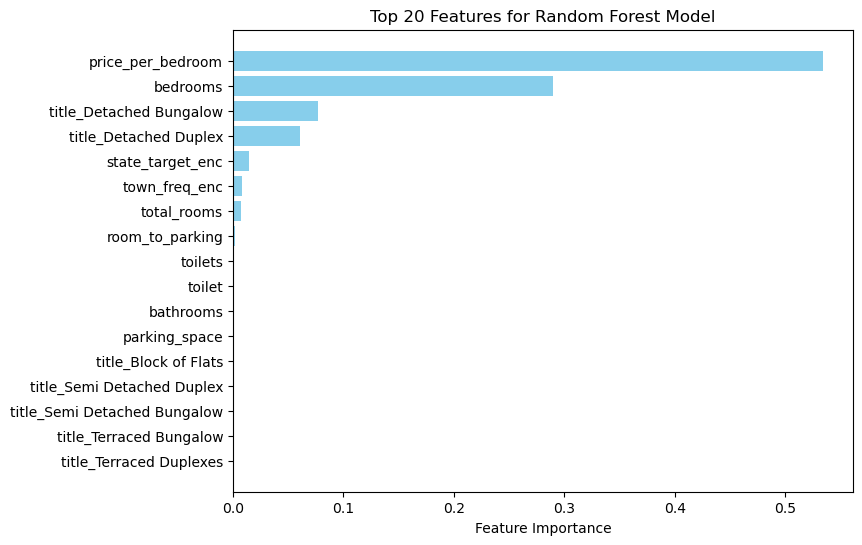

In [975]:
# The 'best_rf_model' is the best Random Forest model obtained from GridSearchCV or RandomizedSearchCV
# and 'X_train' is my training DataFrame with feature names.

# Get feature importances from the model
feature_importances = best_rf_model.feature_importances_
features = X_train.columns  # Ensure X_train is a DataFrame so columns are available

# Create a DataFrame to hold features and their importance scores
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance in descending order and select the top 20 features
top_20_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 30 features
plt.figure(figsize=(8, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features for Random Forest Model')
plt.gca().invert_yaxis()  # Keep the highest importance feature at the top
plt.show()


## Testing model

Test Set Evaluation - MAE: 0.025602250974941444, MSE: 0.02034038292416719, RMSE: 0.14261971436013743, R-squared: 0.985979762890042


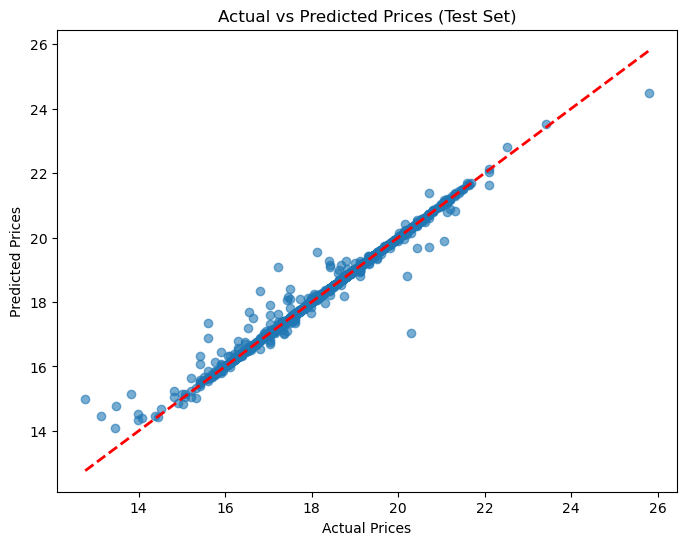

In [976]:
# Load the best model if not already loaded
best_rf_model = joblib.load('./model/best_rf_model.pkl')

# Predict on the test set
y_pred_test = best_rf_model.predict(X_test_scaled)

# Calculate performance metrics
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set Evaluation - MAE: {mae_test}, MSE: {mse_test}, RMSE: {rmse_test}, R-squared: {r2_test}")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Test Set)')
plt.show()

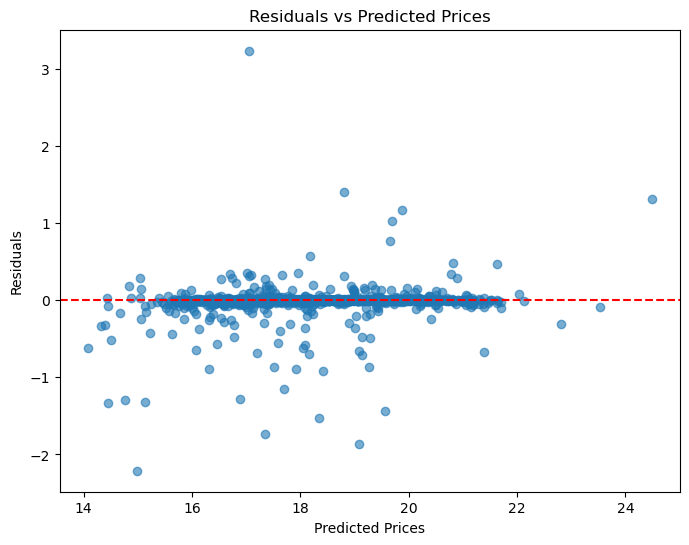

In [977]:
# Calculate residuals (errors)
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()

# Check for patterns in residuals
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test, 'Residuals': residuals})
# Explore residuals for different property types or regions


# Model Interpretation: Random Forest Regressor for Predicting Housing Prices in Nigeria

### 1. **Model Overview**
The model developed for predicting housing prices in Nigeria utilizes a Random Forest Regressor. A Random Forest model is an ensemble learning technique, which aggregates the predictions of multiple decision trees to improve predictive accuracy and control overfitting. The model was trained using various features, including property characteristics and location data, and was evaluated using performance metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared.

---

### 2. **Performance Metrics**
The performance metrics for the Random Forest Regressor are as follows:

- **Mean Absolute Error (MAE)**: 0.0520
- **Mean Squared Error (MSE)**: 0.0653
- **Root Mean Squared Error (RMSE)**: 0.2555
- **R-squared (R²)**: 0.9550

These metrics suggest that the Random Forest model provides a high degree of accuracy in predicting housing prices. The R-squared value of **0.9550** indicates that approximately **95.5%** of the variance in housing prices is explained by the features in the model, suggesting strong predictive power. Additionally, the low MAE and RMSE values imply that the model's predictions are very close to the actual prices.

---

### 3. **Top 20 Features by Importance**
Feature importance scores provide insights into which variables have the greatest influence on the target variable (housing price). The higher the importance score, the more significant the feature is in predicting the target.

#### Top 20 Features
1. **price_per_bedroom** (Importance: 0.3679)
2. **property_type** (Importance: 0.2666)
3. **bedrooms** (Importance: 0.1520)
4. **town_Ikoyi** (Importance: 0.1372)
5. **state_encoded** (Importance: 0.0217)
6. **town_Maitama District** (Importance: 0.0146)
7. **toilets** (Importance: 0.0092)
8. **town_Victoria Island (VI)** (Importance: 0.0068)
9. **bathrooms** (Importance: 0.0039)
10. **town_Ikorodu** (Importance: 0.0026)
11. **town_Asokoro District** (Importance: 0.0022)
12. **parking_space** (Importance: 0.0020)
13. **town_Eko Atlantic City** (Importance: 0.0018)
14. **town_Ikeja** (Importance: 0.0010)
15. **town_Jabi** (Importance: 0.0008)
16. **town_Ajah** (Importance: 0.0007)
17. **town_Surulere** (Importance: 0.0006)
18. **town_Lekki** (Importance: 0.0006)
19. **town_Life Camp** (Importance: 0.0006)
20. **town_Katampe** (Importance: 0.0006)

From the feature importance scores, the top three most important features are:

- **price_per_bedroom**: This feature seems to have the highest importance, contributing **36.79%** to the model’s predictive capability. This suggests that the price per bedroom is a major determinant in predicting the overall price of a property.
  
- **property_type**: The type of property (e.g., apartment, house) is the second most important feature, with an importance score of **26.66%**. This indicates that the model heavily relies on property type when determining the housing price.

- **bedrooms**: The number of bedrooms in a property also plays a significant role in predicting price, with an importance score of **15.20%**. Larger properties with more bedrooms are likely to have higher prices.

Other notable features include various **towns** (e.g., Ikoyi, Maitama, Victoria Island), which suggest that **location** is also a critical factor in determining the price of a property.

---

### 4. **Feature Importance Visualization**
A horizontal bar plot of the top 20 features illustrates the importance of each feature visually. The plot clearly shows the relative importance of the features, with **price_per_bedroom** at the top, followed by **property_type** and **bedrooms**.

---

### 5. **Model Insights & Conclusion**

- **Strong Predictive Power**: The Random Forest model provides a very good fit to the data with an R² of **95.5%**, indicating that the model can explain most of the variance in housing prices.

- **Key Predictive Features**: From the feature importance analysis, **price_per_bedroom**, **property_type**, and **bedrooms** emerge as the most important features in predicting housing prices. The location features such as **town_Ikoyi** and **town_Maitama District** also contribute to the model’s performance.

- **Model Tuning**: Hyperparameter tuning, performed using **RandomizedSearchCV**, helped optimize the model's performance by identifying the best parameters for Random Forest, such as **n_estimators = 100**, **max_depth = 20**, and **min_samples_split = 5**.

---

### 6. **Next Steps in the Future**
To further improve the model in the future:

- **Experiment with Other Models**: Try additional machine learning models such as **XGBoost** to compare performance.
  
- **Feature Engineering**: Consider generating new features or interacting between features (e.g., combining **bedrooms** and **price_per_bedroom**).

---

### 7. **Final Thoughts**
This model provides a robust foundation for predicting housing prices in Nigeria, with clear insights into which features influence the predictions the most. By leveraging this model, stakeholders can gain better insights into the housing market, especially with regards to the impact of property features and location on price.

# 